In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test_images.pkl', 'train_images.pkl', 'train_labels.csv']


In [2]:
#Files are stored in pickle format.
#Load them like how you load any pickle. The data is a numpy array
import pandas as pd
train_images = pd.read_pickle('../input/train_images.pkl')
train_labels = pd.read_csv('../input/train_labels.csv')

In [3]:
train_images.shape

(40000, 64, 64)

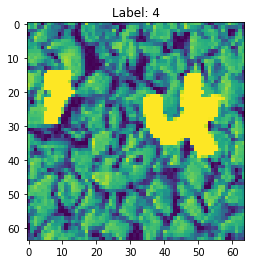

In [4]:
import matplotlib.pyplot as plt

#Let's show image with id 16
img_idx = 16

plt.title('Label: {}'.format(train_labels.iloc[img_idx]['Category']))
plt.imshow(train_images[img_idx])